## Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Let's start with a very basic synthetic dataset sine wave.

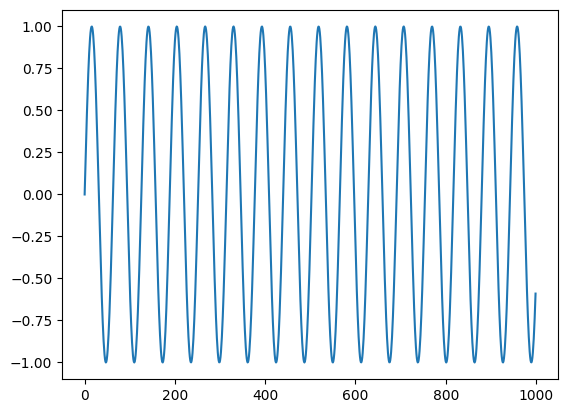

In [ ]:
# Make the data
N = 1000
series = np.sin(0.1*np.arange(N))
# We've created a sine wave with no noise


# Plot the data
plt.plot(series)
plt.show()

In [ ]:
# Build the dataset
T = 10

# We want to see if we can use past 10 data to predict the new data
# Hence, T = 10

X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print(f"Shape of X : {X.shape} & Shape of Y : {Y.shape}")

Shape of X : (990, 10, 1) & Shape of Y : (990, 1)


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## RNN's on PyTorch

```python
class SimpleRNN(nn.Module):

  def __init__(self, ........):
    super().__init__()

    self.RNN = nn.RNN(
                      input_size = num_inputs,
                      hidden_size = num_hidden,
                      num_layers = num_layers,
                      nonlinearity = 'relu',
                      batch_first = True)
```

The code block above is basic way to set up RNN in PyTorch.<br>
<br>
We can see that initializing RNNs' is quiet different than ANNs' and CNNs'.<br>
In fact, with most deeplearning libraries, RNNs' is where things start to get complicated.<br>
<br>
In ANN and CNN, there's straightforward process where we have input, layers and output.<br>
But RNNs' are tricky because they have feedback loops.<br>
<br>
Let's look at the parameters inside `nn.RNN`.<br>
We're familiar with the first two parameters `input_size` and `hidden_size`.<br>
Let's look at `num_layers` : In ANN and CNN, we nned to manually add layers using <br>`nn.Linear` or `nn.Conv2d` but with RNN, we can just specify the values as argument to `num_layers`.<br>
<br>
Also, the `nonlinearity = 'relu'` means that we donot need to specify <br>non linearity explicitly after each layers like we did in CNN and ANN. <br>
<br>
`batch_first = True` tells sequence data will be of shape `N x T x D`

```python
def forward(self, X):

  # initial hidden states - L x N x M
  h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

  # Get RNN unit output
  # Output is od size (N, T, M)
  out, _ = self.rnn(X, h0)

  # We only want h(T) at the final time step
  # N x M -> N x K
  out = self.fc(out[:, -1, :])
  return out
```

In the code cell above, we can see that the `forward()` function is also<br>
quiet different that ANN and CNN.<br>
<br>
The output depends not only on input and weights but also on the previous hidden state.<br>
<br>
So, before we even call the RNN, we initialize hidden state with all zeros.<br>
<br>
Output also looks quiet different, It's because RNN gives a different output.<br>
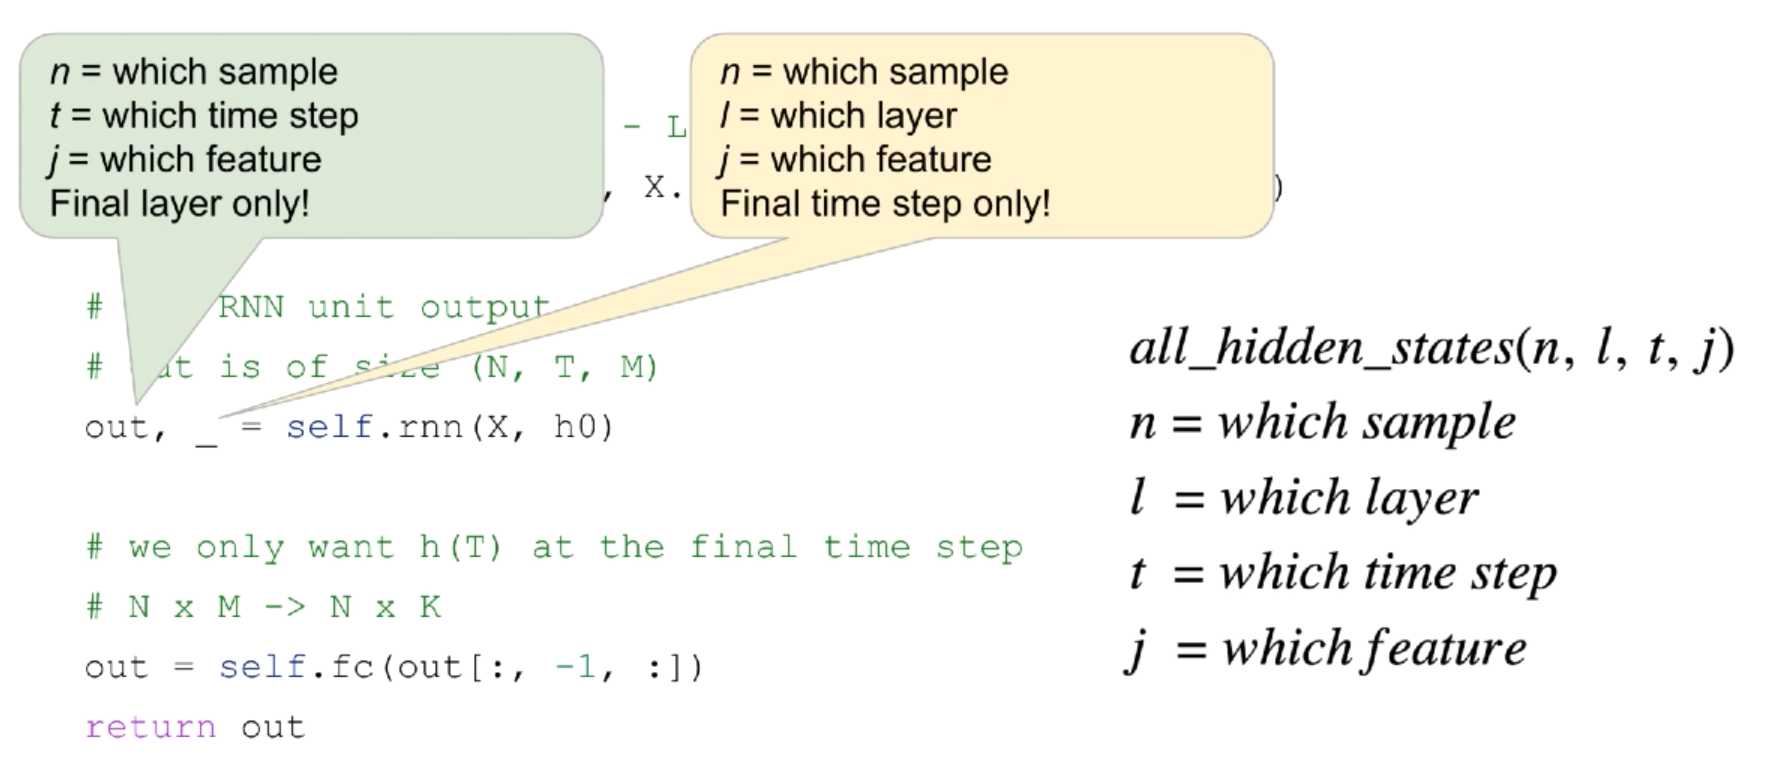

In [ ]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size = self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N,T,M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X[:-N//2].astype(np.float32()))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32()))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32()))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32()))


In [ ]:
# mode data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Training
## full gradiant descent != batch gradient descent
## we use the full dataset because in this case, its small
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch  {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test)

Epoch  5/200, Train Loss: 0.5128, Test Loss: 0.5261
Epoch  10/200, Train Loss: 0.4962, Test Loss: 0.4788
Epoch  15/200, Train Loss: 0.3678, Test Loss: 0.3073
Epoch  20/200, Train Loss: 0.0924, Test Loss: 0.0958
Epoch  25/200, Train Loss: 0.0917, Test Loss: 0.0843
Epoch  30/200, Train Loss: 0.0693, Test Loss: 0.0622
Epoch  35/200, Train Loss: 0.0278, Test Loss: 0.0219
Epoch  40/200, Train Loss: 0.0114, Test Loss: 0.0122
Epoch  45/200, Train Loss: 0.0149, Test Loss: 0.0127
Epoch  50/200, Train Loss: 0.0044, Test Loss: 0.0036
Epoch  55/200, Train Loss: 0.0054, Test Loss: 0.0058
Epoch  60/200, Train Loss: 0.0045, Test Loss: 0.0039
Epoch  65/200, Train Loss: 0.0031, Test Loss: 0.0034
Epoch  70/200, Train Loss: 0.0035, Test Loss: 0.0032
Epoch  75/200, Train Loss: 0.0027, Test Loss: 0.0027
Epoch  80/200, Train Loss: 0.0029, Test Loss: 0.0028
Epoch  85/200, Train Loss: 0.0025, Test Loss: 0.0025
Epoch  90/200, Train Loss: 0.0026, Test Loss: 0.0025
Epoch  95/200, Train Loss: 0.0024, Test Loss: 0

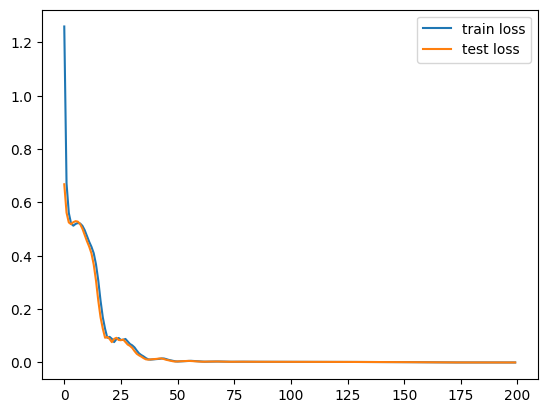

In [ ]:
# Plot the train loss and testloss per iteraiton
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# "Wrong forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1,T,1) # since N and D = 1
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

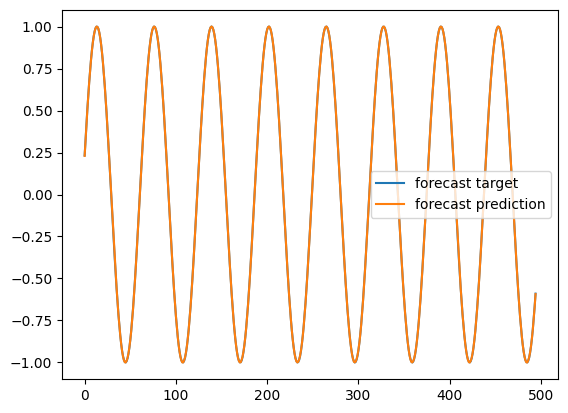

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# "correct forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

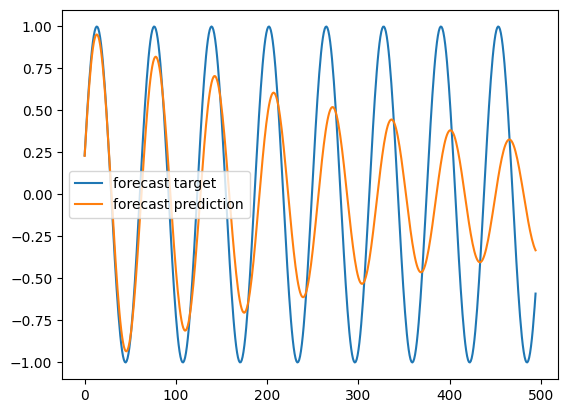

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Same data but with noise

## Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Let's start with a very basic synthetic dataset sine wave.

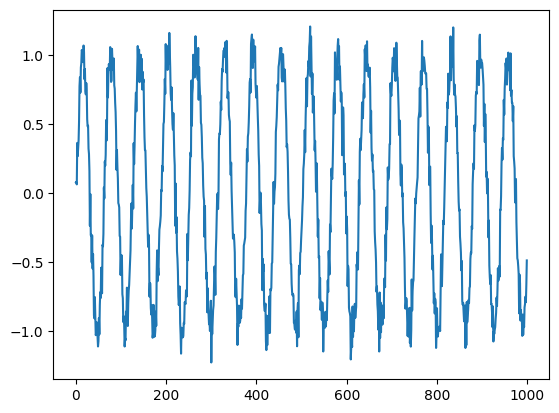

In [ ]:
# Make the data
N = 1000
series = np.sin(0.1*np.arange(N))  + np.random.randn(N)*0.1
# We've created a sine wave with no noise


# Plot the data
plt.plot(series)
plt.show()

In [ ]:
# Build the dataset
T = 10

# We want to see if we can use past 10 data to predict the new data
# Hence, T = 10

X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print(f"Shape of X : {X.shape} & Shape of Y : {Y.shape}")

Shape of X : (990, 10, 1) & Shape of Y : (990, 1)


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size = self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N,T,M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X[:-N//2].astype(np.float32()))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32()))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32()))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32()))


In [ ]:
# mode data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Training
## full gradiant descent != batch gradient descent
## we use the full dataset because in this case, its small
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch  {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test)

Epoch  5/200, Train Loss: 0.1187, Test Loss: 0.7179
Epoch  10/200, Train Loss: 0.0758, Test Loss: 0.0515
Epoch  15/200, Train Loss: 0.1249, Test Loss: 0.1156
Epoch  20/200, Train Loss: 0.0451, Test Loss: 0.0427
Epoch  25/200, Train Loss: 0.0330, Test Loss: 0.0363
Epoch  30/200, Train Loss: 0.0412, Test Loss: 0.0369
Epoch  35/200, Train Loss: 0.0286, Test Loss: 0.0312
Epoch  40/200, Train Loss: 0.0281, Test Loss: 0.0310
Epoch  45/200, Train Loss: 0.0231, Test Loss: 0.0257
Epoch  50/200, Train Loss: 0.0245, Test Loss: 0.0272
Epoch  55/200, Train Loss: 0.0234, Test Loss: 0.0258
Epoch  60/200, Train Loss: 0.0236, Test Loss: 0.0261
Epoch  65/200, Train Loss: 0.0228, Test Loss: 0.0257
Epoch  70/200, Train Loss: 0.0228, Test Loss: 0.0257
Epoch  75/200, Train Loss: 0.0224, Test Loss: 0.0253
Epoch  80/200, Train Loss: 0.0224, Test Loss: 0.0251
Epoch  85/200, Train Loss: 0.0223, Test Loss: 0.0251
Epoch  90/200, Train Loss: 0.0222, Test Loss: 0.0250
Epoch  95/200, Train Loss: 0.0221, Test Loss: 0

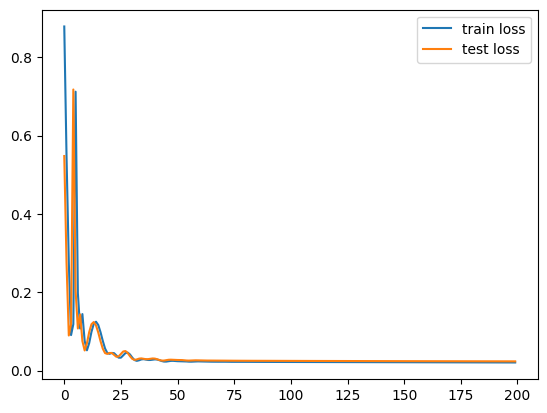

In [ ]:
# Plot the train loss and testloss per iteraiton
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# "Wrong forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1,T,1) # since N and D = 1
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

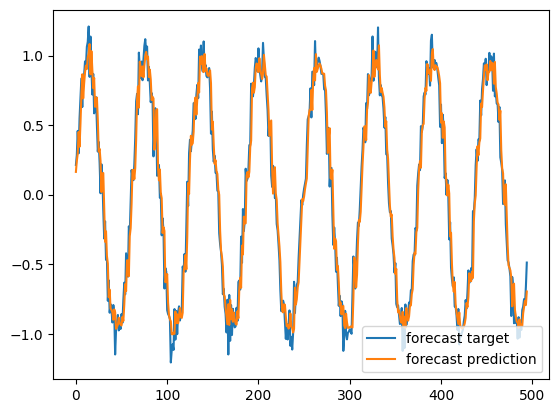

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# "correct forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

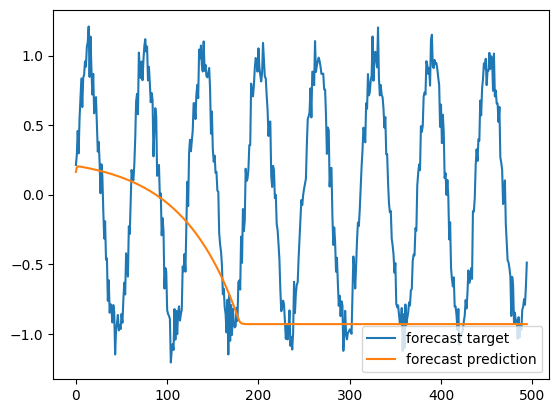

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

This is because RNN has too much flexibility.